# VAR Model Rolling 1-Step Ahead Forecast

## Import Libraries

In [2]:
import pandas as pd
import numpy as np
from statsmodels.tsa.api import VAR
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt
import warnings
warnings.filterwarnings('ignore')

## Load Data

In [3]:
PATHS = {
    'CPI': 'CPIAUCSL (1).csv',
    'INDPRO': 'INDPRO (1).csv',
    'M2SL': 'M2SL.csv',
    'FEDFUNDS': 'FEDFUNDS.csv',
    'GS10': 'GS10.csv',
    'BRENT': 'DCOILBRENTEU.csv'
}

def load_monthly_csv(path):
    df = pd.read_csv(path)
    date_col = df.columns[0]
    df[date_col] = pd.to_datetime(df[date_col], infer_datetime_format=True, errors='coerce')
    df = df.set_index(date_col)
    df = df.resample('M').last()
    numcols = df.select_dtypes(include=[float,int]).columns
    df = df[[numcols[0]]]  # pick numeric column
    df.columns = [None]
    return df

series = {}
for name, path in PATHS.items():
    series[name] = load_monthly_csv(path)
    series[name].columns = [name]

data = pd.concat(list(series.values()), axis=1).dropna(how='all')

## Feature Engineering

In [4]:
data['inflation'] = 120 * np.log(data['CPI'] / data['CPI'].shift(1))
data['indpro_growth'] = 120 * np.log(data['INDPRO'] / data['INDPRO'].shift(1))
data['m2_growth'] = 120 * np.log(data['M2SL'] / data['M2SL'].shift(1))
data['brent_log'] = np.log(data['BRENT'].replace(0, np.nan))

var_df = data[['inflation','indpro_growth','m2_growth','FEDFUNDS','GS10','brent_log']].dropna()

## Rolling 1-Step Ahead VAR Forecast

In [5]:
HOLDOUT_MONTHS = 12
test = var_df.iloc[-HOLDOUT_MONTHS:]
predictions = []
prediction_index = test.index

for i in range(HOLDOUT_MONTHS):
    train = var_df.iloc[:-(HOLDOUT_MONTHS - i)]
    model = VAR(train)
    try:
        sel = model.select_order(12)
        selected_lag = sel.selected_orders.get('aic', 4)
    except:
        selected_lag = 4
    res = model.fit(selected_lag)
    fc = res.forecast(train.values[-selected_lag:], 1)[0]
    predictions.append(fc)

pred_df = pd.DataFrame(predictions, index=prediction_index, columns=train.columns)
results = pd.DataFrame({
    'actual_inflation': test['inflation'],
    'forecast_inflation': pred_df['inflation']
})

## Evaluation Metrics

In [ ]:
rmse = sqrt(mean_squared_error(results['actual_inflation'], results['forecast_inflation']))
mae = mean_absolute_error(results['actual_inflation'], results['forecast_inflation'])
mape = np.mean(np.abs((results['actual_inflation'] - results['forecast_inflation']) / results['actual_inflation'])) * 100

rmse, mae, mape


12-Month Ahead Horizon RMSE: 0.07990498142149566


## Plot Forecast vs Actual

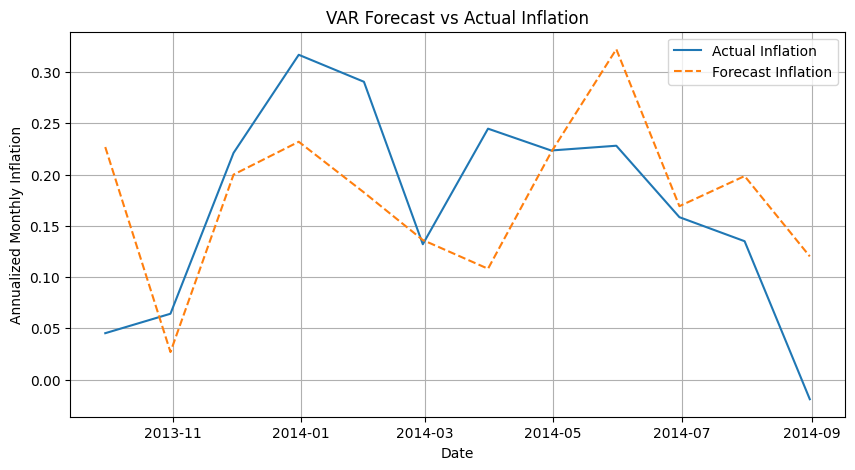

In [9]:
plt.figure(figsize=(10,5))
plt.plot(results.index, results['actual_inflation'], label='Actual Inflation')
plt.plot(results.index, results['forecast_inflation'], label='Forecast Inflation', linestyle='--')
plt.title('VAR Forecast vs Actual Inflation')
plt.xlabel('Date')
plt.ylabel('Annualized Monthly Inflation')
plt.grid(True)
plt.legend()
plt.show()